In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
from sklearn.model_selection import train_test_split
import shutil
import xml.etree.ElementTree as ET

In [17]:
# Set the path to the dataset directory
BASEPATH = "../datasets/stanford-dogs-dataset/images/Images/"
anotation_path = "../datasets/stanford-dogs-dataset/annotations/Annotation"


In [18]:
os.walk(BASEPATH)

<generator object _walk at 0x7f1000301a10>

In [19]:
# Set the directory to the dataset images
filelist  = []
for dirname, _, filenames in os.walk(BASEPATH):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))
print('Total number of images:', len(filelist))

Total number of images: 20580


In [20]:
# Split the file paths and the labels
Filepaths = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)
num_classes = len(set(labels)) 
print('Total number of labels:', num_classes)

Total number of labels: 120


In [21]:
# Create a Pandas dataframe to store the file paths and labels, and shuffle the dataframe
df = pd.DataFrame(list(zip(Filepaths, labels)), columns = ['Filepath', 'Labels'] )
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [22]:
df.head()

,Filepath,Labels
0,../datasets/stanford-dogs-dataset/images/Image...,n02106166-Border_collie
1,../datasets/stanford-dogs-dataset/images/Image...,n02108422-bull_mastiff
2,../datasets/stanford-dogs-dataset/images/Image...,n02087046-toy_terrier
3,../datasets/stanford-dogs-dataset/images/Image...,n02115641-dingo
4,../datasets/stanford-dogs-dataset/images/Image...,n02108915-French_bulldog


In [23]:
# Get the count of each dog breed in the dataset
breed_count = pd.value_counts(df['Labels'], ascending=False)
print('Top 10 dog breeds:')
print(breed_count.tail(10))

Top 10 dog breeds:
n02115913-dhole                     150
n02105056-groenendael               150
n02102177-Welsh_springer_spaniel    150
n02099601-golden_retriever          150
n02102973-Irish_water_spaniel       150
n02104029-kuvasz                    150
n02107142-Doberman                  150
n02106166-Border_collie             150
n02086079-Pekinese                  149
n02090379-redbone                   148
Name: Labels, dtype: int64


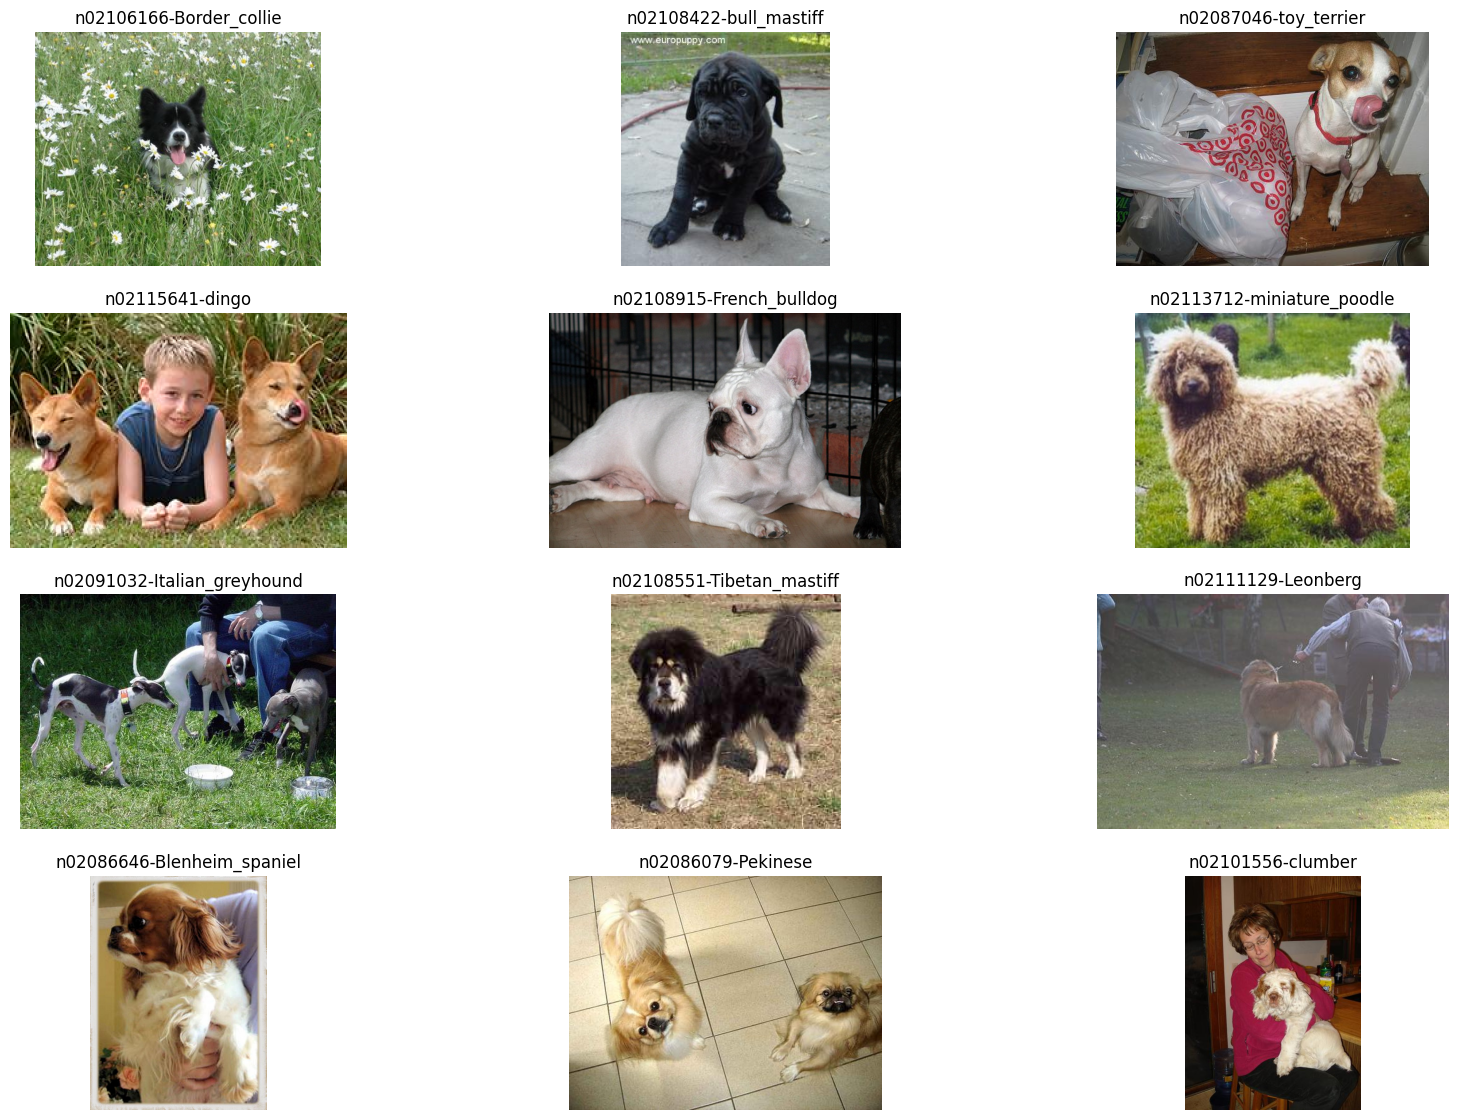

In [24]:
# Display some sample images from the dataset
fig, axis = plt.subplots(4, 3, figsize=(20, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    ax.axis('off')
plt.show()

In [25]:
# Split the dataset into training, validation, and testing sets
val_ratio = test_ratio = 0.2
train, test = train_test_split(df, test_size=test_ratio)
val, test = train_test_split(test, test_size=val_ratio)
print('Total number of samples:', len(df))
print('Number of training samples:', len(train))
print('Number of validation samples:', len(val))
print('Number of testing samples:', len(test))

Total number of samples: 20580
Number of training samples: 16464
Number of validation samples: 3292
Number of testing samples: 824


In [26]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

train.head()


,Filepath,Labels
0,../datasets/stanford-dogs-dataset/images/Image...,n02092339-Weimaraner
1,../datasets/stanford-dogs-dataset/images/Image...,n02097658-silky_terrier
2,../datasets/stanford-dogs-dataset/images/Image...,n02087394-Rhodesian_ridgeback
3,../datasets/stanford-dogs-dataset/images/Image...,n02113978-Mexican_hairless
4,../datasets/stanford-dogs-dataset/images/Image...,n02089078-black-and-tan_coonhound


In [27]:
with open("../dnn_model/breed/class.json", "r") as f:
    breed_classes = json.load(f)
    
breed_classes

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [28]:
def process_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size_element = root.find('.//size')
    width = int(size_element.find('width').text)
    height = int(size_element.find('height').text)

    object_data = []

    for object_element in root.findall('.//object'):
        name_element = object_element.find('name')
        name = name_element.text

        bndbox_element = object_element.find('bndbox')
        xmin = int(bndbox_element.find('xmin').text)
        ymin = int(bndbox_element.find('ymin').text)
        xmax = int(bndbox_element.find('xmax').text)
        ymax = int(bndbox_element.find('ymax').text)

        # Normalize the bounding box values
        x = (xmin + xmax) / (2 * width)
        y = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        object_data.append((name, x, y, bbox_width, bbox_height))

    return object_data

In [29]:
def extract_df(dataframe, dir_name):
    print(f"Starting to Process {dir_name} dir")
    count = 0
    for index, row in dataframe.iterrows():
        img_path = row['Filepath']
        img_filename = os.path.basename(img_path)
        img_name, img_ext = os.path.splitext(img_filename)
        label = row['Labels']
        
        # Define new paths
        xml_path = f"../datasets/stanford-dogs-dataset/annotations/Annotation/{label}/{img_name}"
        new_img_path = f"../datasets/dog-breed-yolo_dataset/{dir_name}/images/{img_filename}"
        new_txt_path = f"../datasets/dog-breed-yolo_dataset/{dir_name}/labels/{img_name}.txt"
        object_data_list = process_xml(xml_path)


        # Write the converted values to the new TXT file
        with open(new_txt_path, 'w') as file:
            for name, x, y, bbox_width, bbox_height in object_data_list:
                # Set the object-class-id according to the label name (replace with your actual class IDs)
                object_class_id = breed_classes[name]
                file.write(f"{object_class_id} {x:.6f} {y:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
        
        # Copy the image file to the new destination
        shutil.copyfile(img_path, new_img_path)
        count += 1
    print(f"Processed {count} files into {dir_name}")

In [30]:
extract_df(train, "train")

Starting to Process train dir
Processed 16464 files into train


In [31]:
extract_df(val, "valid")

Starting to Process valid dir
Processed 3292 files into valid


In [32]:
extract_df(test, "test")

Starting to Process test dir
Processed 824 files into test
